In [22]:
%load_ext autoreload
%autoreload 2

import music21 as mu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from data_helper import *
from music_helper import *

dataId = 1
pathes = [
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-1_fingering.txt",
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-2_fingering.txt",
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-5_fingering.txt",
    f"./tmp/PianoFingeringDataset/FingeringFiles/{dataId:03d}-8_fingering.txt",
    f'./tmp/Result_FHMM1/{dataId:03d}-1_fingering.txt',
    f'./tmp/Result_FHMM2/{dataId:03d}-1_fingering.txt',
    f'./tmp/Result_FHMM3/{dataId:03d}-1_fingering.txt',
    f'./data/{dataId:03d}-Czerny_fingering.csv',
    f'./data/{dataId:03d}-my_fingering.csv',
]
titles = [
    "PIG_1",
    "PIG_2",
    "PIG_5",
    "PIG_8",
    "FHMM1",
    "FHMM2",
    "FHMM3",
    "Czerny",
    "Ref",
]
filenames = [f"{dataId:03d}-{title}" for title in titles]
tables = [read_PIG(path) for path in pathes]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

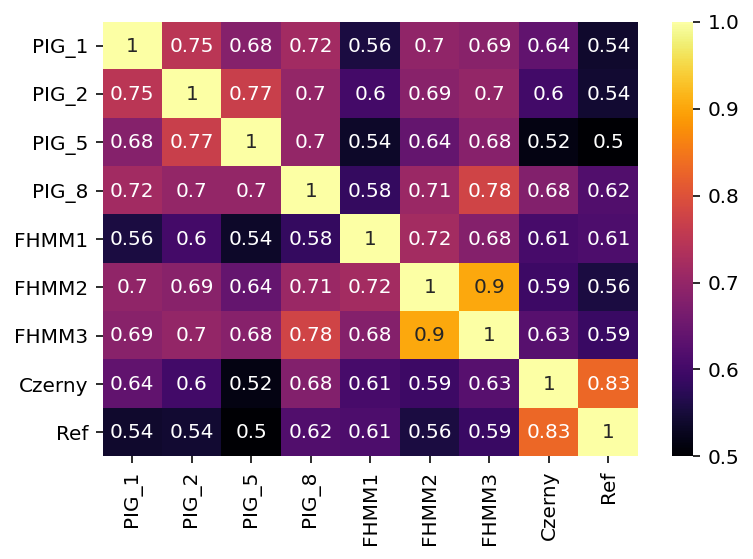

In [23]:
def make_match_matrix(pig_array, ch):
    pig_fingers = [table.finger for table in pig_array]
    data_length = len(pig_fingers[0])
    arr = np.zeros(shape = (len(pig_array), len(pig_array)))
    for i, j in itertools.product(range(len(pig_fingers)), range(len(pig_fingers))):
        fingerPair = zip(pig_fingers[i], pig_fingers[j]) # make pair
        cnt = 0
        for _, fs in enumerate(fingerPair):
            if len(set(fs)) < len(fs):
                cnt += 1
        arr[i, j] = cnt / data_length
    df = pd.DataFrame(arr)
    df.columns = titles
    df.index = titles
    return df

df = make_match_matrix(tables, 0)
sns.heatmap(df, cmap=plt.get_cmap("inferno"), vmin = 0.5, vmax = 1.0, annot=True)

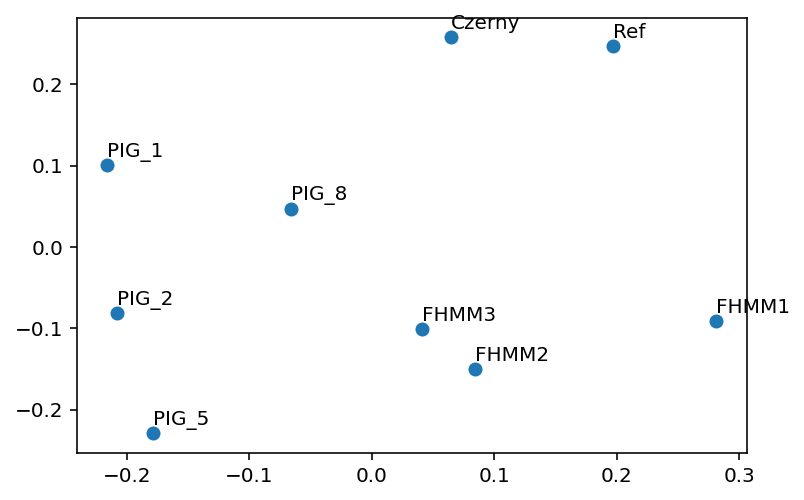

In [24]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state = 1)

df = 1 - make_match_matrix(tables, 0)
pos = mds.fit_transform(df)

plt.scatter(pos[:, 0], pos[:, 1], marker = 'o')
for i, xy in enumerate(zip(pos[:, 0], pos[:, 1])):
    plt.text(xy[0], xy[1] + 0.01, df.columns[i])

        L 5th  L 4th  L 3rd  L 2nd  L 1st  R 1st  R 2nd  R 3rd  R 4th  R 5th
PIG_1    35.0   51.0   59.0   42.0   32.0   39.0   69.0   66.0   54.0   22.0
PIG_2    43.0   56.0   53.0   35.0   32.0   44.0   68.0   64.0   50.0   24.0
PIG_5    39.0   60.0   54.0   38.0   28.0   44.0   68.0   64.0   49.0   25.0
PIG_8    46.0   61.0   55.0   37.0   20.0   38.0   67.0   70.0   50.0   25.0
FHMM1    62.0   75.0   43.0   22.0   17.0   43.0   74.0   74.0   44.0   15.0
FHMM2    56.0   68.0   49.0   26.0   20.0   51.0   72.0   62.0   48.0   17.0
FHMM3    55.0   67.0   49.0   29.0   19.0   49.0   74.0   61.0   46.0   20.0
Czerny   51.0   62.0   55.0   31.0   20.0   50.0   72.0   67.0   44.0   17.0
Ref      46.0   68.0   56.0   38.0   11.0   50.0   65.0   68.0   51.0   16.0
xi2 = 66.78495702296472


<AxesSubplot:>

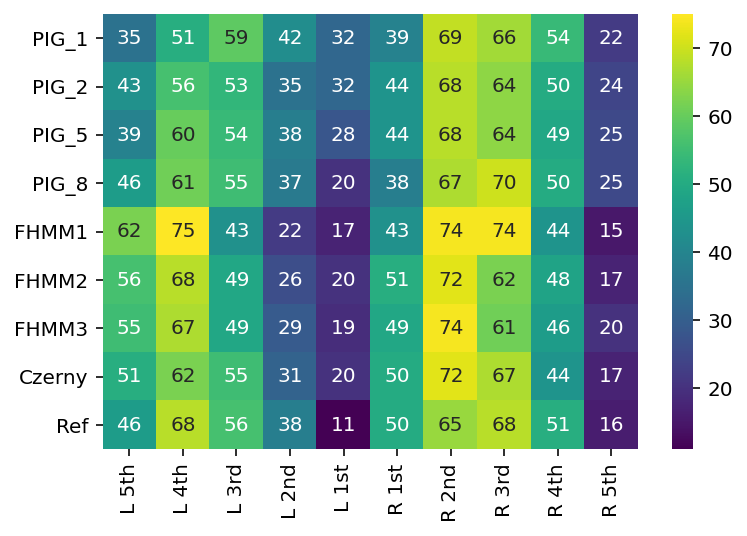

In [25]:
def make_finger_matrix_both_hands(pig_array):
    pig_fingers = [table for table in pig_array]
    arr = np.zeros(shape = (len(pig_fingers), 10))
    for i in range(len(pig_fingers)):
        lefts = pig_fingers[i][pig_fingers[i].ch == 1].finger
        rights = pig_fingers[i][pig_fingers[i].ch == 0].finger
        for j in range(0, 5):
            arr[i, j] = len(lefts[lefts == -j - 1])
        for j in range(5, 10):
            arr[i, j] = len(rights[rights == (j - 5 + 1)])
    df = pd.DataFrame(arr, columns = ["L 5th", "L 4th", "L 3rd", "L 2nd", "L 1st", "R 1st", "R 2nd", "R 3rd", "R 4th", "R 5th"])
    return df

df = make_finger_matrix_both_hands(tables)
df.index = titles
print(df)

expect = df.sum() / len(tables)
df_e = df - expect
df_xi = (df_e * df_e / expect)
xi = df_xi.sum().sum()
print(f"xi2 = {xi}")

sns.heatmap(df, annot=True, cmap = "viridis")

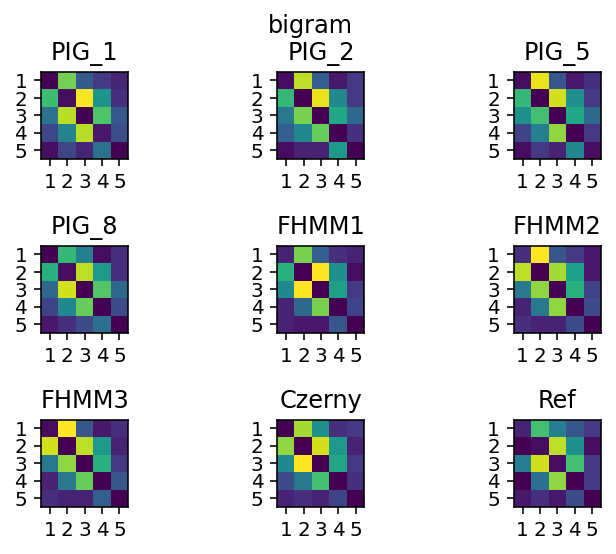

In [28]:
def make_finger_transition_table(pig, ch):
    fingers = pig[pig.ch == ch].finger
    a = np.ndarray(shape = (5, 5), dtype = float)
    for i, z in enumerate(zip(fingers.shift(1), fingers)):
        if i == 0:
            continue
        a[int(z[0]) - 1, int(z[1]) - 1] += 1
    return a

fig, ax = plt.subplots(3, 3)
fig.subplots_adjust(hspace = 1)
fig.suptitle("bigram")
for i in range(len(tables)):
    df = make_finger_transition_table(tables[i], 0)
    a = ax[int(i / 3), int(i % 3)]
    a.set_title(titles[i])
    a.set_xticks(range(5))
    a.set_yticks(range(5))
    a.set_xticklabels([i + 1 for i in range(5)])
    a.set_yticklabels([i + 1 for i in range(5)])
    img = a.imshow(df, cmap=plt.get_cmap("viridis"), vmin = 0, vmax = 30)
#fig.colorbar(img)

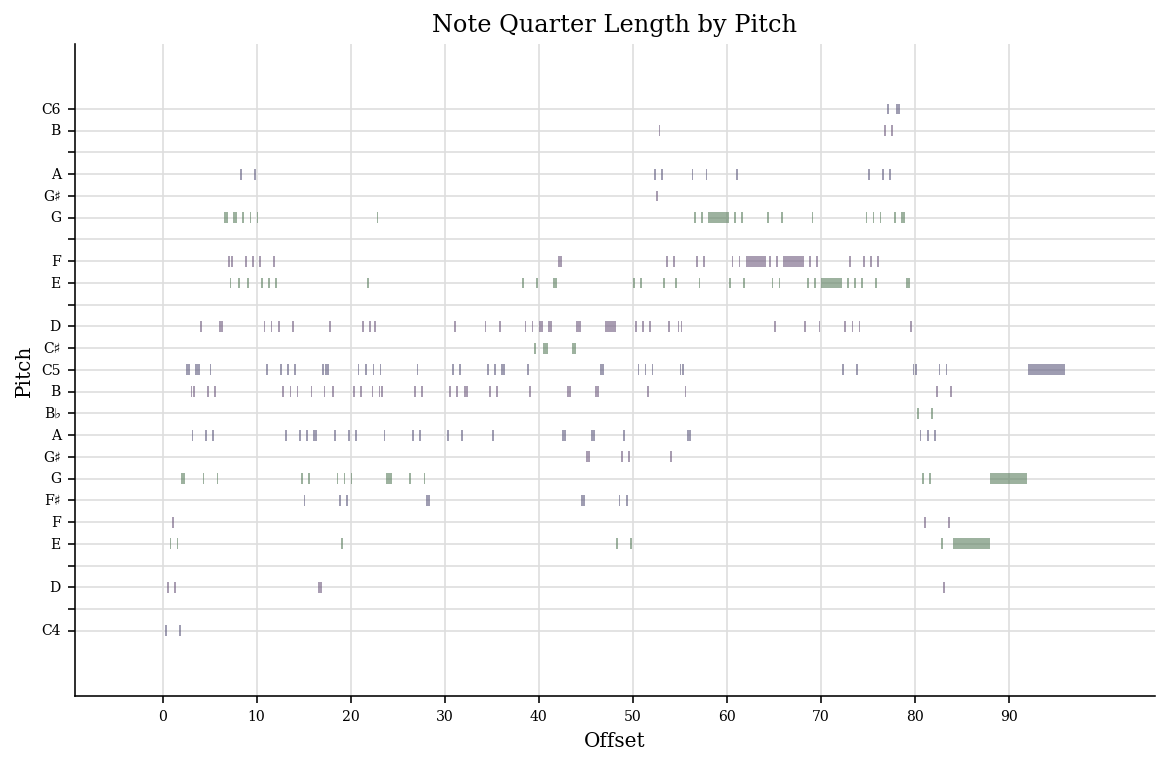

In [29]:
# https://miso-soup3.hateblo.jp/entry/2018/12/20/223705
table = tables[0]
score = makeScore(table)
score.parts[0].plot()

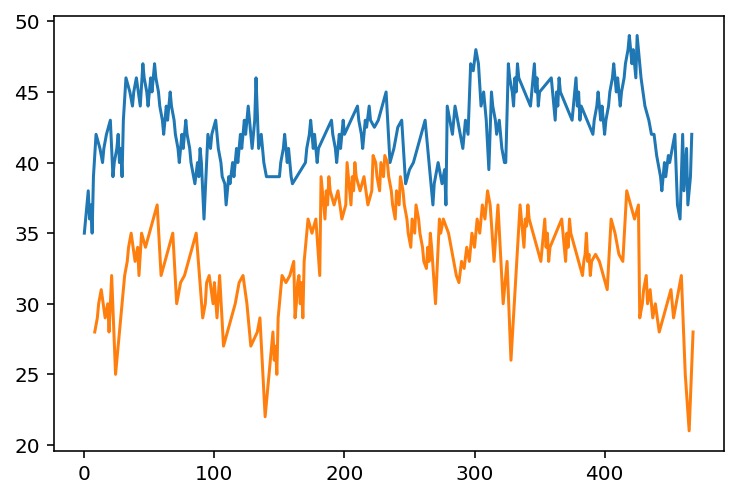

In [30]:
plt.plot(table[table.ch == 0].pos)
plt.plot(table[table.ch == 1].pos)

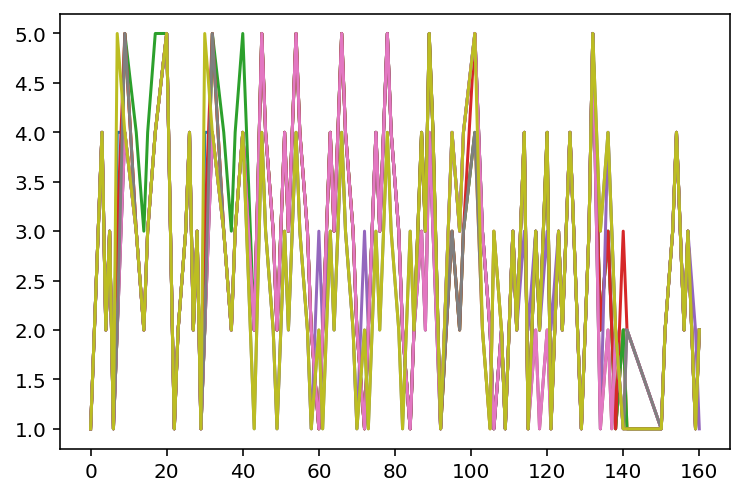

In [31]:
ch = 0
for p, table in enumerate(tables):
    notes = table[table.ch == ch]
    plt.plot(notes.finger[0:100])